# LangSmith 사용 방법

## 0. 사전 작업
1.  [setup](../../setup/README.md) 의 가이드에 따라 실행하여, 가상 환경인 langgraph 생성

2. ../../.env 파일을 생성하고 아래의 내용을 작성
    ```
    LANGSMITH_TRACING=true
    LANGSMITH_API_KEY=your_langsmith_api_key
    OPENAI_API_KEY=your_openai_api_key
    ```
3. langsmith 에 [로그인](https://smith.langchain.com/)
- ![langsimth_login.png](img/langsimth_login.png)

## 1. 환경 설정

In [6]:
%load_ext autoreload
%autoreload 2

import sys, os

def add_python_path(module_path):
    if os.path.abspath(module_path) not in sys.path:
        sys.path.append(os.path.abspath(module_path))
        print(f"python path: {os.path.abspath(module_path)} is added")
    else:
        print(f"python path: {os.path.abspath(module_path)} already exists")
    print("sys.path: ", sys.path)


module_path = "../.."
add_python_path(module_path)

from utils.langgraph_util import ( 
        show_graph_dag,
)

python path: /home/sagemaker-user/Self-Study-Generative-AI/lab/02-lang-graph is added
sys.path:  ['/home/sagemaker-user/Self-Study-Generative-AI/lab/02-lang-graph/warmming-up/langsmith', '/home/sagemaker-user/.conda/envs/langgraph/lib/python310.zip', '/home/sagemaker-user/.conda/envs/langgraph/lib/python3.10', '/home/sagemaker-user/.conda/envs/langgraph/lib/python3.10/lib-dynload', '', '/home/sagemaker-user/.conda/envs/langgraph/lib/python3.10/site-packages', '/home/sagemaker-user/Self-Study-Generative-AI/lab/02-lang-graph']


## 2. 환경 변수 로딩
아래와 같은 환경 변수를 로딩 함.
```
LANGSMITH_TRACING=true
LANGSMITH_API_KEY=your_langsmith_api_key
OPENAI_API_KEY=your_openai_api_key
```

In [2]:
from dotenv import load_dotenv

# .env 파일에서 환경 변수 로드
load_dotenv("../../.env")



True

## 3. langsmith project 지정

In [3]:
import os

# 환경 변수로 프로젝트 이름 설정
os.environ["LANGSMITH_PROJECT"] = "250308-how-to-setup-langsmith"

## 4. 코드 실행

In [4]:
from typing import Literal

from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph import StateGraph, MessagesState
from langgraph.prebuilt import ToolNode

@tool
def search(query: str):
    """Call to surf the web."""
    if "sf" in query.lower() or "san francisco" in query.lower():
        return "It's 60 degrees and foggy."
    return "It's 90 degrees and sunny."

tools = [search]

tool_node = ToolNode(tools)

model = ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(tools)

def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "__end__"


def call_model(state: MessagesState):
    messages = state['messages']

    # Invoking `model` will automatically infer the correct tracing context
    response = model.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge("__start__", "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", 'agent')

app = workflow.compile()

final_state = app.invoke(
    {"messages": [HumanMessage(content="what is the weather in sf")]},
    config={"configurable": {"thread_id": 42}}
)
final_state["messages"][-1].content

'The current weather in San Francisco is 60 degrees and foggy.'

## 5. Graph 구조 보기

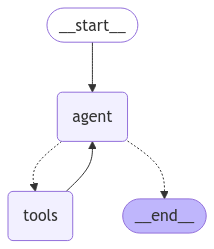

In [7]:
show_graph_dag(app)    

## 6. LangSmith Tracing Output
![langsmith_output.png](img/langsmith_output.png)